DeePyMoD ODE Example

In [28]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
# from torch.autograd import grad
# from itertools import combinations
# from functools import reduce
# from typing import Tuple
# from deepymod.utils.types import TensorList
# from deepymod.model.library import Library
import libraryODE

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if False: #torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


# Preparing a new dataset
Firstly we prepare the dataset.
Therfore we load the time series from .mat file and transform it into a Dataset object.

### Simulated with miaSim

Interaction matrix 
$A = \begin{pmatrix}
-0.5 & 20 & 0 & 0 & 0 \\
-28 & -0.5 & 0 & 0 & 0 \\
0 & 0 & -0.5 & 0 & -20 \\
0 & 0 & 0 & -0.5 & -60 \\
0 & 0 & 0 & 40 & -0.5
\end{pmatrix}$

and growth rates:
$ b = (10, -1, 4, 10, -10)$

Specify the number of species n_species and the number of timepoints n_samples in the given dataset:

In [29]:
# n_samples = None
# n_species = None

n_samples = 500
n_species = 5

# path of data file
filename = f"miaSim_GLV_{n_species}species_fewInteractions.mat"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/explore/data/01e-timeseries-miaSim/" + filename

# data should be of the form:
# [n_samples, (1 + n_species)]
# where the first colum contains the time t

# order of interactions included in the model (2 or 3)
int_order = 2

In [30]:
def create_data():
  data = loadmat(filepath)
  usol = np.real(data["ts_glv"]).astype("float32")
  usol = usol.reshape((n_samples, (1 + n_species)))
  ts = usol[:, 0]
  data_y = usol[:, 1:(1 + n_species)]
  T = torch.from_numpy(ts.reshape(-1, 1)).float()
  Y = torch.from_numpy(data_y).float()
  print("The coodinates have shape {}".format(T.shape))
  print("The data has shape {}".format(Y.shape))
  return T, Y

In [31]:
data = create_data()
print("Time:", data[0][0:10])
print("Data:", data[1][0:10])

The coodinates have shape torch.Size([500, 1])
The data has shape torch.Size([500, 5])
Time: tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.]])
Data: tensor([[6.8917e-01, 7.1316e-01, 8.2951e-01, 2.8598e-01, 4.1347e-01],
        [2.7026e-04, 1.2696e-01, 1.4958e+00, 4.6428e-01, 2.7923e-01],
        [1.6837e-04, 4.0222e-01, 1.6228e+00, 4.0470e-01, 2.6516e-01],
        [4.6446e-02, 7.9455e-01, 1.4919e+00, 2.9209e-01, 2.7870e-01],
        [2.4235e-01, 2.0995e-01, 1.3252e+00, 2.0275e-01, 2.4734e-01],
        [9.0488e-02, 1.7421e-01, 1.2546e+00, 1.7081e-01, 1.8895e-01],
        [6.6788e-02, 1.9695e-01, 1.2930e+00, 1.8562e-01, 1.4413e-01],
        [7.1399e-02, 2.2229e-01, 1.3947e+00, 2.3313e-01, 1.2683e-01],
        [8.6728e-02, 2.5090e-01, 1.4882e+00, 2.8639e-01, 1.3857e-01],
        [1.0298e-01, 2.8882e-01, 1.4983e+00, 2.9662e-01, 1.7010e-01]])


Then we pass this function to the dataset class, which then adds noise to it, normalizes the coordinates and performs random subsampling to it.

In [32]:
def custom_normalize(feature):
        """minmax all features by their absolute maximum
        Args:
            feature (torch.tensor): data to be minmax normalized
        Returns:
            (torch.tensor): minmaxed data"""
        return (feature/feature.abs().max(axis=0).values)

In [33]:
# # add noise to dataset
# dataset = Dataset(
#     create_data,
#     subsampler=Subsample_random,
#     subsampler_kwargs={"number_of_samples": 500},
#     preprocess_kwargs={
#         "noise_level": 0.01,
#         "normalize_coords": False,
#         "normalize_data": False,
#     },
#     apply_normalize=custom_normalize,
#     device=device
# )

In [34]:
dataset = Dataset(
    create_data,
    device = device,
)

The coodinates have shape torch.Size([500, 1])
The data has shape torch.Size([500, 5])
Dataset is using device:  cpu


Visualization of the dataset

Text(0.5, 1.0, 'Sampled and standardized data')

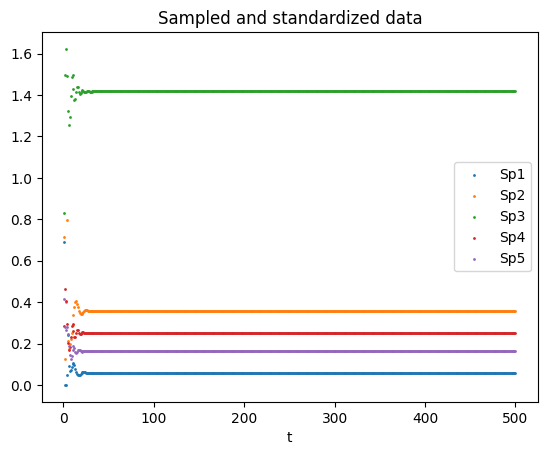

In [35]:
fig, ax = plt.subplots()
for i in np.arange(n_species):
    # plt.plot(dataset.coords.cpu(), dataset.data[:, i].cpu(), label = f"Sp{i+1}")
    ax.scatter(dataset.coords.cpu(), dataset.data[:, i].cpu(), label = f"Sp{i+1}", s=1)
ax.set_xlabel("t")
ax.legend()
ax.set_title("Sampled and standardized data")
# plt.xlim([0,100])

Now we need to split our data into a train and test dataloaders for PyTorch

In [36]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [37]:
network = NN(1, [20, 20, 20, 20, 20], n_species)

Configuration of the library function.

In [38]:
library = libraryODE.LibraryODE(int_order = int_order, intercept = False)

Show a list of the expressions contained in the library.

In [39]:
library.get_content(dataset.data)

[['x1*1', 'x1*x1', 'x1*x2', 'x1*x3', 'x1*x4', 'x1*x5'],
 ['x2*1', 'x2*x1', 'x2*x2', 'x2*x3', 'x2*x4', 'x2*x5'],
 ['x3*1', 'x3*x1', 'x3*x2', 'x3*x3', 'x3*x4', 'x3*x5'],
 ['x4*1', 'x4*x1', 'x4*x2', 'x4*x3', 'x4*x4', 'x4*x5'],
 ['x5*1', 'x5*x1', 'x5*x2', 'x5*x3', 'x5*x4', 'x5*x5']]

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.

In [40]:
estimator = Threshold(0.1)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)

Configuration of the sparsity estimator

In [41]:
constraint = LeastSquares()

Now we instantiate the model and select the optimizer

In [42]:
model = DeepMoD(network, library, estimator, constraint)# .to(device)

Defining optimizer

In [43]:
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=5e-3
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [44]:
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    # log_dir='runs/coupled/',
    log_dir="/data/deepymod/ODE_S4/",
    max_iterations=50000,
    delta=1e-3,
    patience=100,
)

 49975  MSE: 1.38e-04  Reg: 3.43e-06  L1: 3.47e+02 Algorithm converged. Writing model to disk.


Now that DeepMoD has converged, it has found the following coefficients to not be zero:

In [45]:
model.sparsity_masks

[tensor([False, False,  True,  True,  True, False]),
 tensor([True, True, True, True, True, True]),
 tensor([True, True, True, True, True, True]),
 tensor([ True,  True,  True, False,  True,  True]),
 tensor([ True,  True, False,  True,  True,  True])]

And it found the following coefficients.

In [46]:
model.estimator_coeffs()

[array([[ 0.       ],
        [ 0.       ],
        [ 2.0330348],
        [-0.5287311],
        [-1.0168759],
        [ 0.       ]], dtype=float32),
 array([[-0.55704784],
        [-1.3695847 ],
        [-1.3449147 ],
        [ 0.4607573 ],
        [ 1.7536622 ],
        [ 0.5730426 ]], dtype=float32),
 array([[ 1.9042884 ],
        [-1.7579585 ],
        [-6.884353  ],
        [ 8.175694  ],
        [-1.0940689 ],
        [-0.48705623]], dtype=float32),
 array([[ 0.84904134],
        [ 2.2087457 ],
        [-0.77739793],
        [ 0.        ],
        [ 0.24606295],
        [-2.2063575 ]], dtype=float32),
 array([[ 0.3920832],
        [-0.7869005],
        [ 0.       ],
        [ 0.6209177],
        [ 1.4187704],
        [-2.151484 ]], dtype=float32)]

## Analysis/Visualization of the train() loss

In [47]:
import os
from tensorflow.python.summary.summary_iterator import summary_iterator

In [48]:
# get list of all output values that were calculated during train()
# os.listdir("/data/deepymod/ODE_S4/")

In [49]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_mse_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_mse_output_0/" + tmp_file

train_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        train_loss = np.append(train_loss, mse)
        i += 1

# train_loss

In [50]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/remaining_MSE_test_val_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/remaining_MSE_test_val_0/" + tmp_file

test_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        test_loss = np.append(test_loss, mse)
        i += 1

# test_loss

In [51]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_l1_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_l1_output_0/" + tmp_file

l1_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        l1_loss = np.append(l1_loss, mse)
        i += 1

# l1_loss

In [52]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_reg_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_reg_output_0/" + tmp_file

reg_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        reg_loss = np.append(reg_loss, mse)
        i += 1

# reg_loss

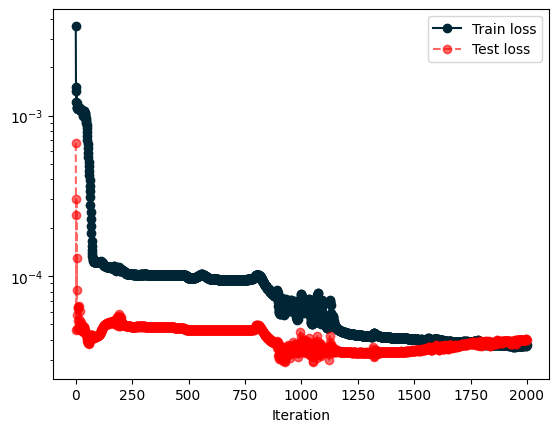

In [53]:
fig, ax = plt.subplots()
ax.plot(train_loss, c='#002635', marker='o', label='Train loss')
ax.plot(test_loss, c='red', marker='o', ls='--', alpha=0.6, label='Test loss')
# ax.plot(reg_loss, c='gray', marker='o', ls='--', alpha=0.6, label='Reg loss')
# ax.plot(l1_loss, c='darkgray', marker='o', ls='--', alpha=0.6, label='L1 loss')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.legend()
# plt.xlim([0, 500])